In [1]:
!pip -q install lxml

In [2]:
# Version 67
# From https://ungoogled-software.github.io/ungoogled-chromium-binaries/releases/linux_portable/64bit/
!wget -q https://github.com/Eloston/ungoogled-chromium-binaries/releases/download/67.0.3396.87-2/ungoogled-chromium_67.0.3396.87-2_linux.tar.xz
!tar -xf ungoogled-chromium_67.0.3396.87-2_linux.tar.xz

# From https://chromedriver.storage.googleapis.com/index.html
!wget -q https://chromedriver.storage.googleapis.com/2.41/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip -d ./ungoogled-chromium_67.0.3396.87-1_linux

Archive:  chromedriver_linux64.zip
  inflating: ./ungoogled-chromium_67.0.3396.87-1_linux/chromedriver  


In [2]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import re
import os
from lxml import etree
import pandas as pd
import numpy as np

'''
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--incognito')
chrome_options.add_argument('log-level=3')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
chrome_options.add_argument("--width=2560")
chrome_options.add_argument("--height=1440")
browser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
'''

'\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument(\'--headless\')\nchrome_options.add_argument(\'--disable-gpu\')\nchrome_options.add_argument(\'--incognito\')\nchrome_options.add_argument(\'log-level=3\')\nchrome_options.add_argument("--disable-dev-shm-usage")\nchrome_options.add_argument("--no-sandbox")\nchrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"\nchrome_options.add_argument("--width=2560")\nchrome_options.add_argument("--height=1440")\nbrowser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)\n'

In [15]:
class youtube(object):
    # init variables
    driver = None
    source = None
    element = None

    def __init__(self):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--incognito')
        chrome_options.add_argument('log-level=3')
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--no-sandbox")
        chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
        self.driver = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
        self.driver.set_window_position(0, 0)
        self.driver.set_window_size(1968, 600)
        
    def fetch(self, id):
        # Ask browser to go to url
        self.driver.get(f'https://www.youtube.com/watch?v={id}')
        # Wait until we have the recommendation panel
        self.element = WebDriverWait(self.driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'ytd-watch-next-secondary-results-renderer')))
        self.source = self.driver.page_source
        return self.element is not None
    
    def getsource(self):
        if self.source:
            return self.source
        else:
            return 'Empty buffer'#self.driver.page_source
    
    def getscreenshot(self):
        self.driver.save_screenshot('test.png')
        return 'Done'
  
    def getrecommend(self):
        html = etree.HTML(self.driver.page_source)
        id = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
        title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
        channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
        result = pd.DataFrame(zip(id,title,channel),columns=['ID','TITLE','CHANNEL'])
        return result
    
    def transcript(self,id='c-7YqBrtuNQ'):
        resp = requests.get(f'https://hierogly.ph/api/transcribe?v={id}',headers={'User-Agent':'Mozilla/5.0'})
        result = re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',resp.json()['text'])
        return result


In [16]:
yt = youtube()

In [17]:
yt.fetch('sv0CE-Vo00g')

True

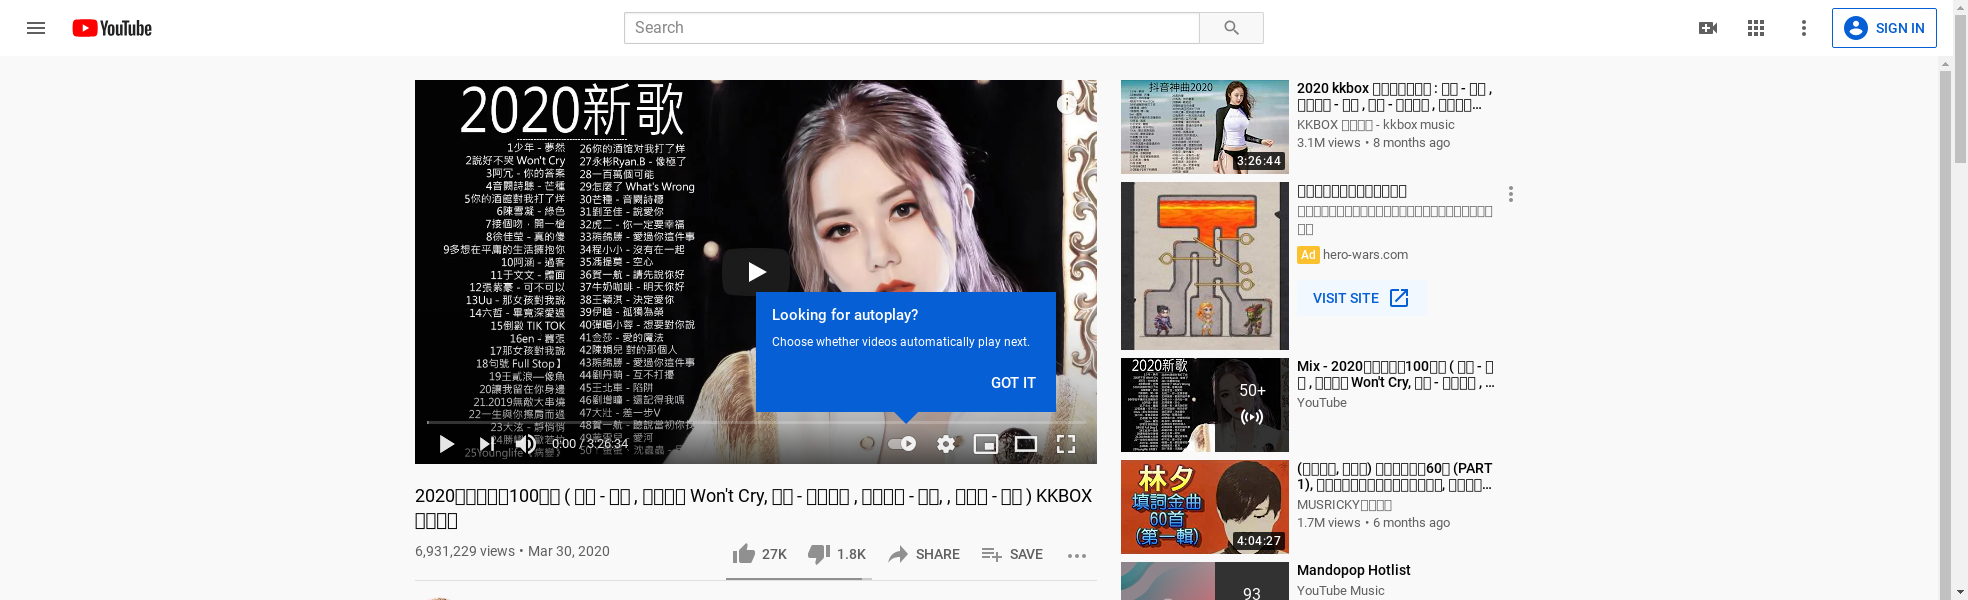

In [18]:
from IPython.display import Image, HTML
yt.getscreenshot()
Image('test.png')

In [19]:
yt.getrecommend()

,ID,TITLE,CHANNEL
0,GcSa2cy__9E,"2020 kkbox 一人一首成名曲 : 少年 - 夢然 , 音闕詩聽 - 芒種 , 阿冗 ...",KKBOX 華語新歌 - kkbox music
1,sv0CE-Vo00g&list,"Mix - 2020不能不聽的100首歌 ( 少年 - 夢然 , 說好不哭 Won't Cr...",YouTube
2,MAktNj5Eh8o,"(全附歌詞, 開字幕) 林夕填詞金曲60首 (PART 1), 這些耳熟能詳的歌詞都是他的手...",MUSRICKY音樂歷奇
3,ymvUlfZCrbw&list,Mandopop Hotlist,YouTube Music
4,Ht23cYaADrM,"#2020不能不聽的100首歌 ( #少年 , Ice Paper - 心如止水 , 音闕...",KKBOX 華語新歌 - kkbox music
5,oTd_c3b1okI,【忧伤古风曲】五十首古风曲合辑 ----- （ 一曲缘歌成绊，留传说，任谁叹。 ）,Chinoiserie
6,rLd8aOcrPJY,Top Songs 2021😻😻 Top Popular Songs Playlist 20...,English Songs
7,A8tl4cZq7V0,陳奕迅精選歌曲30首,那些好听的歌
8,gA80DRt5O40,"Maroon 5, Ed Sheeran, Taylor Swift, Adele, Ari...",Top Music
9,kPcu_5RkJpU,🤠周杰倫歌曲🎧40首精選集🎼年份順序【可自選歌曲】Songs of the Most Pop...,大俠人生旅途Hero's Life Travelling


In [53]:
text = yt.transcript('xi6r3hZe5Tg')

In [55]:
re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',text)

"The paradigm has shifted, the world is accelerating. The science fiction of yesterday is rapidly becoming the science fiction's of right. Now, how do we withstand the tectonic shifts in the world around us? How does a society thrive where the world economy is undergoing constant disruption? When information is moving at the speed of light, there are places that are ahead of the curve. City is building the tools for tomorrow, . We want to create innovations that have a real way impact. One day single pole can be self-sustained in food production. You are looking at the development of Singapore 40 years ahead of time. This city could be a model that wants to come. This is the city of the future. Singapore. The future of the world lies in its urban environments. More than half the world's population live in cities, and that number is growing. This rapid influx of people creates possibility, but it also creates challenges. How can the cities of today grow and thrive to become the places w

In [13]:
html = etree.HTML(yt.driver.page_source)

In [14]:
## Get the IDs from all the anchors
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]

['yLTycPjm0nk',
 'OwpRfRzkS7o',
 'bgPDW0ZpgJU',
 '6ApDLXFPuYQ',
 'kfhgbZBWgBE',
 '9zTa3cAuKLo',
 'xi6r3hZe5Tg',
 'YBH6JjRoPT4',
 'ixIzimI35SE',
 '_ZDEWVJan0s',
 'C65iqOSCZOY',
 'p8ngIL4noF4',
 'OuF9weSkS68',
 'hmrZrw3Ni2s',
 'MNKX1J2iS0k',
 'LWVZK52AA0I',
 'sIO5PwiByLo',
 'kyj2o_Bc22E',
 'yvaSVkb9ykc',
 'ap668oPKAUg']

In [15]:
# Recommended Video Channels
[x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]

['POPtravel',
 'Kumaar Family',
 'Plot11',
 'Spark',
 'Bloomberg Markets and Finance',
 'CNA Insider',
 'National Geographic',
 'Best Ever Food Review Show',
 'Ryan Shirley',
 'Bloomberg Quicktake',
 'Netflix',
 'Spark',
 'ColdFusion',
 'CNA Insider',
 'The Food Ranger',
 'Just Planes',
 'CNA',
 'イーノさん【Logistics YouTuber - IINO san】',
 'SCM Southern Corridor Malaysia',
 'Wall Street Journal']

In [11]:
# Recommended Video IDs
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//span[@id='video-title']/../..")]

['Yi0rhFFXzfA', 'H9zsQ1gjnwI', 'icgV42UPbig', 'hM7ZiyHhCB4']

In [11]:
# Recommended Video Titles
[x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]

['5 Awesome Free Apps to Find Undervalued Properties',
 "Dreams Came Through For This Couple When They Thought It's Impossible!",
 'Can You Really Sell HDB Buy 2 Condo? 🤦\u200d♂️ ("Asset Progression" Explained)',
 'Deep Focus - Music For Studying, Concentration and Work',
 '2020 EXECUTIVE CONDO CAN BUY?',
 'Penrose Review! Will it be Launch of the Year?',
 'How HDB Negative Sale Can Own 2 Condos!',
 'How to Double Your Property Portfolio When You have 2 Condos!',
 'Revealing My Entire $21M Property Investment Portfolio by 33 Years Old',
 'Handel: Messiah | Barnaby Smith, AAM, VOCES8, Apollo5 and VOCES8 Foundation Choir',
 'The New Enhanced CPF Housing Grant | Investors Ep 22',
 "Don't Regret Wrong Property Decisions! How To Buy Your First Real Estate Investment In Singapore",
 'Millionaire HDB Owner! REVEALING the NETWORTH of the SELLER!',
 'BIGGEST mistake by 1st time property buyers!',
 'Sell HDB And buy Condo',
 '99% Failed To Do This!',
 'Launching my Livestream',
 "Don't Buy Woodl

In [12]:
id = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
pd.DataFrame(zip(id,title,channel),columns=['ID','TITLE','CHANNEL'])

,ID,TITLE,CHANNEL
0,33MLF_I4PTw,5 Awesome Free Apps to Find Undervalued Proper...,Eric Chiew
1,GJDsTfUoOho,Dreams Came Through For This Couple When They ...,Eric Chiew
2,OH2pPiQeUac,"Can You Really Sell HDB Buy 2 Condo? 🤦‍♂️ (""As...",Josh Tan - TheAstuteParent
3,oPVte6aMprI,"Deep Focus - Music For Studying, Concentration...",Quiet Quest - Study Music
4,0M676WcRdws,2020 EXECUTIVE CONDO CAN BUY?,Aaron Lin
5,ryLRkWPIB0Y,Penrose Review! Will it be Launch of the Year?,Eric Chiew
6,8q1-eRYrpfo,How HDB Negative Sale Can Own 2 Condos!,Eric Chiew
7,fImbMoc6sjM,How to Double Your Property Portfolio When You...,Eric Chiew
8,uyR1NH78b4I,Revealing My Entire $21M Property Investment P...,Eric Chiew
9,lFjQ77ol2DI,"Handel: Messiah | Barnaby Smith, AAM, VOCES8, ...",Academy of Ancient Music


In [37]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [139]:
transcript('rb_adz0tkOw')

"Both of us, we plant a lot of strawberries la on each other's lands. What * screams * Hi, I'm Bolin, I'm Qing, I'm Peps Hi, I'm Leah, and this is Zula ChickChats. Okay, hi guys welcome to today's episode of ChickChats. Why Are you all very nervous? Yes, this is my first time on ChickChats Welcome And today's episode we'll be talking about being in the grey area as much requested from the comments section below. Ah So we hear you okay, we will do this episode for you guys. So my first question to you guys, then, is what happened. Okay, whoever wants can share first la What happened. Bolin, Let's start with Bolin. No Qing should start because she's the new person. Why me? Oh my god? Yes, What happened. I met the person through an app Okay, So we hit off like we talk, then after that move to Telegram. But the thing right we went out for so many times right. The places we go to right were like-, not the kind of place that you and your friends would go to. For example, For example, I need 

In [122]:
transcript('5L31Wbrg7tE')

"On one of the days um, we were supposed to have a date .... He came to my house like downstairs. Then I no time to draw eyebrows no time to draw anything right. Then we [ sat ] at the lamp post. There [, I made ] sure to choose the dimmest lamppost Hi. I ’ m Julian Hi. I ’ m Amanda Hi. I ’ m John Hi. I ’ m Leah and this is Zula ChickChats Hi guys welcome to today. ’ s, episode of Zula ChickChats And today we ’ re gon na be talking about- the honeymoon phase in relationships. We have 3 people over here to share uh- their honeymoon phases in their relationships. So…. The first Can you: why Can you explain what the honeymoon phase is I ...? What do you mean You don, ’ t know I ’ m married. I forgot about it. It ’ s been a long time ago. Okay, so the honeymoon phase, I guess, would be the period before your relationship starts getting serious, All the butterflies, all the romantic gestures, Oh ..., For the first question: maybe we ’ ll, let the audience know for you guys. How long have yo

In [140]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [145]:
transcript('mPHGGxZwICI')

"My name is I've been working for about two years. My name is Rob. I'Ve been working for about two years, six years, plus I think five years plus I'm very sure, let's see God my location off just nice kata-kata and they realize okay might as well. We just did I just graduated. Yes, I think two years ago yeah - and I guess it just seemed like a natural information from that February. For the column, one poet a key numbers, a thousand by hello, I'm Hansel - I just graduated from in yet last year, and now I'm doing an internship of jewelry come and your student, your tree, we have been together what six? Yes, I think with us always day. Video, what does the you need to be married before you can apply for the blueblack all controller? I mean you're gon na collect the key. Oh boss, you don't need to be married, like yeah, you can apply first, then you get true or false. It is possible to play pain, zero cash yeah. You can actually go share without paying any cash. It wasn't actually, when w